In [1]:
import pandas as pd 
import dask.dataframe as dd
import numpy as np
from sklearn.cluster import DBSCAN
import geopandas as gpd

In [2]:
import dask.distributed 
client = dask.distributed.Client(n_workers=1)
client

Client Scheduler: tcp://127.0.0.1:7934 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 12 Memory: 17.02 GB


U have to read stay points file

In [7]:
# if data frame became large u have to change block size
data_Base = dd.read_csv(r'E:\Arshad\Thesis\Datasets\3000Data\Staypoints sample\3000_5D_stp.csv',parse_dates=['Date_Time'])


# use DBSCAN to cluster our data

In [52]:
data_filtered = data_Base[((data_Base.Date_Time.dt.day_name() == 'Friday') | (data_Base.Date_Time.dt.day_name() == 'Thursday')) & ((data_Base.Date_Time.dt.hour >= 19) | (data_Base.Date_Time.dt.hour <= 1))]
data_filtered.head()

,StayStart,Date_Time,ID,Lat,Long,Duration,cluster,manategh,Day,Week,Purpose
72,2019-08-08 00:44:57,2019-08-08 00:44:57,25512,35.693,51.386,0 days 00:55:17.000000000,0,11.0,Thursday,32,Home
119,2019-08-08 01:36:44,2019-08-08 01:36:44,25927,35.639,51.424,0 days 01:15:25.000000000,1,16.0,Thursday,32,Home
167,2019-08-08 00:42:55,2019-08-08 00:42:55,26344,35.631,51.356,0 days 02:05:06.000000000,0,18.0,Thursday,32,Home
360,2019-08-08 01:07:55,2019-08-08 01:07:55,21918,35.804,51.440,0 days 00:25:13.000000000,0,1.0,Thursday,32,Home
414,2019-08-08 00:56:20,2019-08-08 00:56:20,25887,35.764,51.530,0 days 00:21:32.000000000,3,4.0,Thursday,32,Other


In [9]:
data_Home = data_Base[(data_Base.Purpose == 'Home')][['ID','Lat','Long','manategh','Purpose']]

data_Home=data_Home.drop_duplicates()

In [13]:
data_filtered = dd.merge(data_filtered,data_Home,on='ID',how='inner')
data_filtered.head()

,StayStart,Date_Time,ID,Lat_x,Long_x,Duration,cluster,manategh_x,Day,Week,Purpose_x,Lat_y,Long_y,manategh_y,Purpose_y,Lat,Long,manategh,Purpose
0,2019-08-08 00:44:57,2019-08-08 00:44:57,25512,35.693,51.386,0 days 00:55:17.000000000,0,11.0,Thursday,32,Home,35.693,51.386,11.0,Home,35.693,51.386,11.0,Home
1,2019-08-08 01:36:44,2019-08-08 01:36:44,25927,35.639,51.424,0 days 01:15:25.000000000,1,16.0,Thursday,32,Home,35.639,51.424,16.0,Home,35.639,51.424,16.0,Home
2,2019-08-08 00:42:55,2019-08-08 00:42:55,26344,35.631,51.356,0 days 02:05:06.000000000,0,18.0,Thursday,32,Home,35.631,51.356,18.0,Home,35.631,51.356,18.0,Home
3,2019-08-08 01:07:55,2019-08-08 01:07:55,21918,35.804,51.440,0 days 00:25:13.000000000,0,1.0,Thursday,32,Home,35.804,51.440,1.0,Home,35.804,51.440,1.0,Home
4,2019-08-08 00:56:20,2019-08-08 00:56:20,25887,35.764,51.530,0 days 00:21:32.000000000,3,4.0,Thursday,32,Other,35.738,51.521,4.0,Home,35.738,51.521,4.0,Home


In [30]:
def clust(data_filtered):
    coordinates = data_filtered[['Lat_x','Long_x']]*(np.pi)/180
    dbs = DBSCAN(eps=0.00009, min_samples=6, algorithm='ball_tree', metric='haversine').fit(coordinates)
    f = dbs.labels_
    
    return f

In [31]:
p = data_filtered.map_partitions(clust)


In [32]:
data_filtered['Clust_recreational'] = p #Later we use this for spatial join

In [33]:
data_filtered.head()

,StayStart,Date_Time,ID,Lat_x,Long_x,Duration,cluster,manategh_x,Day,Week,...,Lat_y,Long_y,manategh_y,Purpose_y,Lat,Long,manategh,Purpose,Clust_recreational,Latlong
0,2019-08-08 00:44:57,2019-08-08 00:44:57,25512,35.693,51.386,0 days 00:55:17.000000000,0,11.0,Thursday,32,...,35.693,51.386,11.0,Home,35.693,51.386,11.0,Home,-1,"(35.69300000000001, 51.386)"
1,2019-08-08 01:36:44,2019-08-08 01:36:44,25927,35.639,51.424,0 days 01:15:25.000000000,1,16.0,Thursday,32,...,35.639,51.424,16.0,Home,35.639,51.424,16.0,Home,-1,"(35.639, 51.424)"
2,2019-08-08 00:42:55,2019-08-08 00:42:55,26344,35.631,51.356,0 days 02:05:06.000000000,0,18.0,Thursday,32,...,35.631,51.356,18.0,Home,35.631,51.356,18.0,Home,-1,"(35.631, 51.356)"
3,2019-08-08 01:07:55,2019-08-08 01:07:55,21918,35.804,51.440,0 days 00:25:13.000000000,0,1.0,Thursday,32,...,35.804,51.440,1.0,Home,35.804,51.440,1.0,Home,-1,"(35.804, 51.44)"
4,2019-08-08 00:56:20,2019-08-08 00:56:20,25887,35.764,51.530,0 days 00:21:32.000000000,3,4.0,Thursday,32,...,35.738,51.521,4.0,Home,35.738,51.521,4.0,Home,-1,"(35.764, 51.53)"


In [34]:
data_filtered['Latlong'] = data_filtered[['Lat_x','Long_x']].apply(tuple, axis=1, meta=(None , 'object')) 
data_filtered.head()

,StayStart,Date_Time,ID,Lat_x,Long_x,Duration,cluster,manategh_x,Day,Week,...,Lat_y,Long_y,manategh_y,Purpose_y,Lat,Long,manategh,Purpose,Clust_recreational,Latlong
0,2019-08-08 00:44:57,2019-08-08 00:44:57,25512,35.693,51.386,0 days 00:55:17.000000000,0,11.0,Thursday,32,...,35.693,51.386,11.0,Home,35.693,51.386,11.0,Home,-1,"(35.69300000000001, 51.386)"
1,2019-08-08 01:36:44,2019-08-08 01:36:44,25927,35.639,51.424,0 days 01:15:25.000000000,1,16.0,Thursday,32,...,35.639,51.424,16.0,Home,35.639,51.424,16.0,Home,-1,"(35.639, 51.424)"
2,2019-08-08 00:42:55,2019-08-08 00:42:55,26344,35.631,51.356,0 days 02:05:06.000000000,0,18.0,Thursday,32,...,35.631,51.356,18.0,Home,35.631,51.356,18.0,Home,-1,"(35.631, 51.356)"
3,2019-08-08 01:07:55,2019-08-08 01:07:55,21918,35.804,51.440,0 days 00:25:13.000000000,0,1.0,Thursday,32,...,35.804,51.440,1.0,Home,35.804,51.440,1.0,Home,-1,"(35.804, 51.44)"
4,2019-08-08 00:56:20,2019-08-08 00:56:20,25887,35.764,51.530,0 days 00:21:32.000000000,3,4.0,Thursday,32,...,35.738,51.521,4.0,Home,35.738,51.521,4.0,Home,-1,"(35.764, 51.53)"


# Filter Noises

In [36]:
data_filtered_Reactivity = data_filtered[data_filtered.Clust_recreational != -1 ]   
data_filtered_Reactivity.head()

,StayStart,Date_Time,ID,Lat_x,Long_x,Duration,cluster,manategh_x,Day,Week,...,Lat_y,Long_y,manategh_y,Purpose_y,Lat,Long,manategh,Purpose,Clust_recreational,Latlong
10,2019-08-08 00:37:15,2019-08-08 00:37:15,22111,35.656,51.487,0 days 02:21:53.000000000,1,14.0,Thursday,32,...,35.554,51.409,0.0,Home,35.554,51.409,0.0,Home,0,"(35.656, 51.487)"
20,2019-08-08 00:30:38,2019-08-08 00:30:38,20701,35.691,51.426,0 days 01:44:23.000000000,1,12.0,Thursday,32,...,35.704,51.453,7.0,Home,35.704,51.453,7.0,Home,1,"(35.691, 51.426)"
21,2019-08-08 00:30:38,2019-08-08 00:30:38,20701,35.691,51.426,0 days 01:44:23.000000000,1,12.0,Thursday,32,...,35.704,51.453,7.0,Home,35.702,51.448,7.0,Home,1,"(35.691, 51.426)"
22,2019-08-08 00:30:38,2019-08-08 00:30:38,20701,35.691,51.426,0 days 01:44:23.000000000,1,12.0,Thursday,32,...,35.704,51.453,7.0,Home,35.691,51.426,12.0,Home,1,"(35.691, 51.426)"
23,2019-08-08 00:30:38,2019-08-08 00:30:38,20701,35.691,51.426,0 days 01:44:23.000000000,1,12.0,Thursday,32,...,35.702,51.448,7.0,Home,35.704,51.453,7.0,Home,1,"(35.691, 51.426)"


# Convert data to pandas DataFrame

In [37]:
data = data_filtered_Reactivity.compute()


In [38]:
data.rename(columns ={'Lat_x':'RELat','Long_x':'RELong','manategh_x':'REZones','Lat_y':'Homelat','Long_y':'Homelong','manategh_y':'Homezone'},inplace=True)
data.drop(columns=['Purpose_x','Purpose_y'],inplace=True)
data

,StayStart,Date_Time,ID,RELat,RELong,Duration,cluster,REZones,Day,Week,Homelat,Homelong,Homezone,Lat,Long,manategh,Purpose,Clust_recreational,Latlong
10,2019-08-08 00:37:15,2019-08-08 00:37:15,22111,35.656,51.487,0 days 02:21:53.000000000,1,14.0,Thursday,32,35.554,51.409,0.0,35.554,51.409,0.0,Home,0,"(35.656, 51.487)"
20,2019-08-08 00:30:38,2019-08-08 00:30:38,20701,35.691,51.426,0 days 01:44:23.000000000,1,12.0,Thursday,32,35.704,51.453,7.0,35.704,51.453,7.0,Home,1,"(35.691, 51.426)"
21,2019-08-08 00:30:38,2019-08-08 00:30:38,20701,35.691,51.426,0 days 01:44:23.000000000,1,12.0,Thursday,32,35.704,51.453,7.0,35.702,51.448,7.0,Home,1,"(35.691, 51.426)"
22,2019-08-08 00:30:38,2019-08-08 00:30:38,20701,35.691,51.426,0 days 01:44:23.000000000,1,12.0,Thursday,32,35.704,51.453,7.0,35.691,51.426,12.0,Home,1,"(35.691, 51.426)"
23,2019-08-08 00:30:38,2019-08-08 00:30:38,20701,35.691,51.426,0 days 01:44:23.000000000,1,12.0,Thursday,32,35.702,51.448,7.0,35.704,51.453,7.0,Home,1,"(35.691, 51.426)"
24,2019-08-08 00:30:38,2019-08-08 00:30:38,20701,35.691,51.426,0 days 01:44:23.000000000,1,12.0,Thursday,32,35.702,51.448,7.0,35.702,51.448,7.0,Home,1,"(35.691, 51.426)"
25,2019-08-08 00:30:38,2019-08-08 00:30:38,20701,35.691,51.426,0 days 01:44:23.000000000,1,12.0,Thursday,32,35.702,51.448,7.0,35.691,51.426,12.0,Home,1,"(35.691, 51.426)"
26,2019-08-08 00:30:38,2019-08-08 00:30:38,20701,35.691,51.426,0 days 01:44:23.000000000,1,12.0,Thursday,32,35.691,51.426,12.0,35.704,51.453,7.0,Home,1,"(35.691, 51.426)"
27,2019-08-08 00:30:38,2019-08-08 00:30:38,20701,35.691,51.426,0 days 01:44:23.000000000,1,12.0,Thursday,32,35.691,51.426,12.0,35.702,51.448,7.0,Home,1,"(35.691, 51.426)"
28,2019-08-08 00:30:38,2019-08-08 00:30:38,20701,35.691,51.426,0 days 01:44:23.000000000,1,12.0,Thursday,32,35.691,51.426,12.0,35.691,51.426,12.0,Home,1,"(35.691, 51.426)"


Calculate centroids for Clusters

In [39]:
centroid = data[['RELat','RELong','Clust_recreational']].groupby('Clust_recreational',as_index=False).mean()
centroid.rename(columns={'RELat':'REcentroid','RELong':'REcentroid'},inplace=True)
centroid

,Clust_recreational,REcentroid,REcentroid
0,0,35.656000,51.487000
1,1,35.691000,51.426000
2,2,35.622571,51.487786
3,3,35.742000,51.534000
4,4,35.712000,51.457000
5,5,35.690500,51.373333


we use this to merge centroids with merged dataframe

In [40]:
data = data.merge(centroid,on='Clust_recreational',how='outer')



In [41]:
data.reset_index()

,index,StayStart,Date_Time,ID,RELat,RELong,Duration,cluster,REZones,Day,...,Homelong,Homezone,Lat,Long,manategh,Purpose,Clust_recreational,Latlong,REcentroid,REcentroid
0,0,2019-08-08 00:37:15,2019-08-08 00:37:15,22111,35.656,51.487,0 days 02:21:53.000000000,1,14.0,Thursday,...,51.409,0.0,35.554,51.409,0.0,Home,0,"(35.656, 51.487)",35.656000,51.487000
1,1,2019-08-08 01:01:37,2019-08-08 01:01:37,19702,35.656,51.487,0 days 00:11:56.000000000,0,14.0,Thursday,...,51.487,14.0,35.656,51.487,14.0,Home,0,"(35.656, 51.487)",35.656000,51.487000
2,2,2019-08-08 01:40:03,2019-08-08 01:40:03,19702,35.656,51.487,0 days 00:10:20.000000000,0,14.0,Thursday,...,51.487,14.0,35.656,51.487,14.0,Home,0,"(35.656, 51.487)",35.656000,51.487000
3,3,2019-08-08 00:04:22,2019-08-08 00:04:22,26404,35.656,51.487,0 days 01:03:04.000000000,0,14.0,Thursday,...,51.487,14.0,35.656,51.487,14.0,Home,0,"(35.656, 51.487)",35.656000,51.487000
4,4,2019-08-08 00:04:22,2019-08-08 00:04:22,26404,35.656,51.487,0 days 01:03:04.000000000,0,14.0,Thursday,...,51.487,14.0,35.692,51.490,13.0,Home,0,"(35.656, 51.487)",35.656000,51.487000
5,5,2019-08-08 00:04:22,2019-08-08 00:04:22,26404,35.656,51.487,0 days 01:03:04.000000000,0,14.0,Thursday,...,51.490,13.0,35.656,51.487,14.0,Home,0,"(35.656, 51.487)",35.656000,51.487000
6,6,2019-08-08 00:04:22,2019-08-08 00:04:22,26404,35.656,51.487,0 days 01:03:04.000000000,0,14.0,Thursday,...,51.490,13.0,35.692,51.490,13.0,Home,0,"(35.656, 51.487)",35.656000,51.487000
7,7,2019-08-08 00:30:38,2019-08-08 00:30:38,20701,35.691,51.426,0 days 01:44:23.000000000,1,12.0,Thursday,...,51.453,7.0,35.704,51.453,7.0,Home,1,"(35.691, 51.426)",35.691000,51.426000
8,8,2019-08-08 00:30:38,2019-08-08 00:30:38,20701,35.691,51.426,0 days 01:44:23.000000000,1,12.0,Thursday,...,51.453,7.0,35.702,51.448,7.0,Home,1,"(35.691, 51.426)",35.691000,51.426000
9,9,2019-08-08 00:30:38,2019-08-08 00:30:38,20701,35.691,51.426,0 days 01:44:23.000000000,1,12.0,Thursday,...,51.453,7.0,35.691,51.426,12.0,Home,1,"(35.691, 51.426)",35.691000,51.426000


# count NoOf Activity and Anntena for each Cluster 
To decide which cluster is Recreational

In [42]:
l=[]
gp = data.groupby('Clust_recreational')
for i in data.Clust_recreational.unique():
    Total_num = gp.get_group(i)['Lat'].shape[0]
    #NoofuniqueAtenna = gp.get_group(i).Latlong.unique().shape[0]
    l.append([i,Total_num])


clustdetail = pd.DataFrame(l,columns=['Clust','Total Activity'])

In [43]:
clustdetail

,Clust,Total Activity
0,0,7
1,1,9
2,2,14
3,3,6
4,4,11
5,5,6


In [44]:
clustdetail.Clust.unique()

array([0, 1, 2, 3, 4, 5], dtype=int64)

Then u have to decide which cluster no u need by two factor (Total Activity,No of Anntena)


In [45]:
import matplotlib.pyplot as plt

In [46]:
clustdetail.sort_values('Total Activity',ascending=False,inplace=True)
clustdetail.reset_index(inplace = True)
clustdetail.head()

,index,Clust,Total Activity
0,2,2,14
1,4,4,11
2,1,1,9
3,0,0,7
4,3,3,6


This is for decision making 

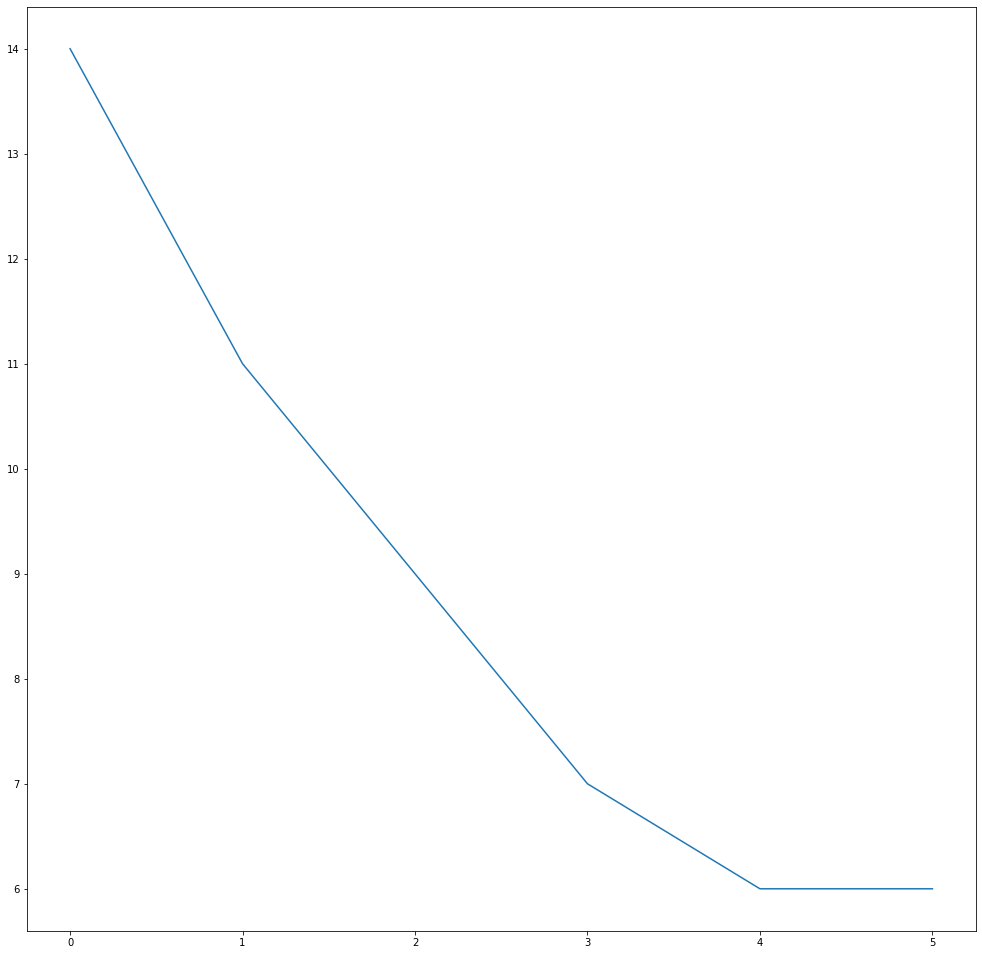

In [47]:
plt.figure(figsize=(17,17))
plt.plot(clustdetail.index,clustdetail['Total Activity'])

collect clusters to use them as recreational clusters

In [48]:
ClusterCollection = clustdetail['Clust'].loc[:40].to_list()

In [49]:
Collected = data[data.Clust_recreational.isin(ClusterCollection)]
Collected.head()

,StayStart,Date_Time,ID,RELat,RELong,Duration,cluster,REZones,Day,Week,...,Homelong,Homezone,Lat,Long,manategh,Purpose,Clust_recreational,Latlong,REcentroid,REcentroid
0,2019-08-08 00:37:15,2019-08-08 00:37:15,22111,35.656,51.487,0 days 02:21:53.000000000,1,14.0,Thursday,32,...,51.409,0.0,35.554,51.409,0.0,Home,0,"(35.656, 51.487)",35.656,51.487
1,2019-08-08 01:01:37,2019-08-08 01:01:37,19702,35.656,51.487,0 days 00:11:56.000000000,0,14.0,Thursday,32,...,51.487,14.0,35.656,51.487,14.0,Home,0,"(35.656, 51.487)",35.656,51.487
2,2019-08-08 01:40:03,2019-08-08 01:40:03,19702,35.656,51.487,0 days 00:10:20.000000000,0,14.0,Thursday,32,...,51.487,14.0,35.656,51.487,14.0,Home,0,"(35.656, 51.487)",35.656,51.487
3,2019-08-08 00:04:22,2019-08-08 00:04:22,26404,35.656,51.487,0 days 01:03:04.000000000,0,14.0,Thursday,32,...,51.487,14.0,35.656,51.487,14.0,Home,0,"(35.656, 51.487)",35.656,51.487
4,2019-08-08 00:04:22,2019-08-08 00:04:22,26404,35.656,51.487,0 days 01:03:04.000000000,0,14.0,Thursday,32,...,51.487,14.0,35.692,51.490,13.0,Home,0,"(35.656, 51.487)",35.656,51.487


# Use pivot table to count transitions between users home and recreational clusters

In [50]:
pd.pivot_table(Collected,aggfunc=(lambda x: x.count()),index=['Homezone'],columns=['Clust_recreational'],values=['ID'])

ID                          
Clust_recreational    0    1     2    3    4    5
Homezone                                         
0.0                 1.0  NaN   NaN  NaN  NaN  NaN
4.0                 NaN  NaN   NaN  4.0  1.0  NaN
7.0                 NaN  6.0   NaN  NaN  7.0  NaN
8.0                 NaN  NaN   NaN  NaN  3.0  NaN
10.0                NaN  NaN   NaN  2.0  NaN  4.0
11.0                NaN  NaN   NaN  NaN  NaN  2.0
12.0                NaN  3.0   NaN  NaN  NaN  NaN
13.0                2.0  NaN   NaN  NaN  NaN  NaN
14.0                4.0  NaN   NaN  NaN  NaN  NaN
15.0                NaN  NaN  13.0  NaN  NaN  NaN
19.0                NaN  NaN   1.0  NaN  NaN  NaN

In [51]:
#r[(r.Clust_recreational==28) & (r.Homezone==1)]     #This is for checking

# Spatial join for Recrational Activity

In [25]:
#data = data.repartition(partition_size='5MB')

In [ ]:
df = data_filtered[['ID','Lat_x','Long_x','Clust_recreational']]
df.head()

In [ ]:
def spj(df):
    
    shp1 = gpd.read_file('E:tehrn.shp') #send this for mr Rahmani
    shp = shp1.to_crs({'init': 'epsg:4326'})
    geodf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(x=df.Long_x, y=df.Lat_x), crs={'init': 'epsg:4326'})
    joined_data =gpd.sjoin(geodf, shp, how='left',op='within')
    
    
    return joined_data
    

In [ ]:
out = df.map_partitions(spj)

data_Base.to_csv('E:outreJoined.csv')

In [30]:
Collected.to_csv('E:pp.csv') #this is for test